# Customer Churn Prediction

### Imports

In [303]:
# Tools
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lifelines import KaplanMeierFitter, CoxPHFitter
from xgboost import XGBClassifier

# Visualisation
import matplotlib.pyplot as plt
from lime import lime_tabular
import math
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [304]:
#adding the values in the csv file to a dataframe 'dataset'
dataset = pd.read_csv("../dataset/dataset.csv")
#we dont require customerID for visualsiation
dataset = dataset.drop(columns='customerID')
#checking the top 5 entries to get an idea
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [305]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Total Charges is listed as an object while logically it should be a float variable

In [306]:
#changing the datatype of Total Charges to numeric float
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors="coerce")

In [307]:
#checking the unique values in the dataset
dataset_columns = dataset.columns.tolist()
for column in dataset_columns:
    print(f"{column} unique values : {dataset[column].unique()}")

gender unique values : ['Female' 'Male']
SeniorCitizen unique values : [0 1]
Partner unique values : ['Yes' 'No']
Dependents unique values : ['No' 'Yes']
tenure unique values : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService unique values : ['No' 'Yes']
MultipleLines unique values : ['No phone service' 'No' 'Yes']
InternetService unique values : ['DSL' 'Fiber optic' 'No']
OnlineSecurity unique values : ['No' 'Yes' 'No internet service']
OnlineBackup unique values : ['Yes' 'No' 'No internet service']
DeviceProtection unique values : ['No' 'Yes' 'No internet service']
TechSupport unique values : ['No' 'Yes' 'No internet service']
StreamingTV unique values : ['No' 'Yes' 'No internet service']
StreamingMovies unique values : ['No' 'Yes' 'No internet service']
Contract unique values : ['Month-to-month' 'O

In [308]:
new_columns = [re.sub(r'(?<!^)([A-Z])', r' \1', col).title() for col in dataset.columns]
new_columns[-8] = 'Streaming TV'
dataset.columns = new_columns

In [309]:
#statistical values of the numerical data
dataset.describe()

,Senior Citizen,Tenure,Monthly Charges,Total Charges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [310]:
#now checking for null values
dataset.isna().sum()

Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure                0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn                 0
dtype: int64

In [311]:
value_na = [value for value in dataset.columns if dataset[value].isnull().sum() > 1]

In [312]:
#exploring the entries with null values
dataset[dataset[value_na[0]].isnull()]

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [313]:
dataset["Payment Method"].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [314]:
#the word automatic are not useful in the analysis
dataset["Payment Method"] = dataset["Payment Method"].str.replace(" (automatic)", "", regex=False)
dataset["Payment Method"].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

### Setting Target Customers aside for Prediction

In [315]:
dataset['Multiple Lines'] = dataset['Multiple Lines'].replace(to_replace='No phone service', value='No service')
dataset.loc[:, ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']] = dataset.loc[:, ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']].replace(to_replace='No internet service', value='No service')

In [316]:
# Checking for Null Values
dataset.isna().sum()

Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure                0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn                 0
dtype: int64

In [317]:
# Seperating Categorical and Numerical columns
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()
numerical_columns = [col for col in dataset.columns if col not in categorical_columns]

### Data Visualisation

In [318]:
# Setting Seaborn Theme Style
sns.set_theme(style='darkgrid')

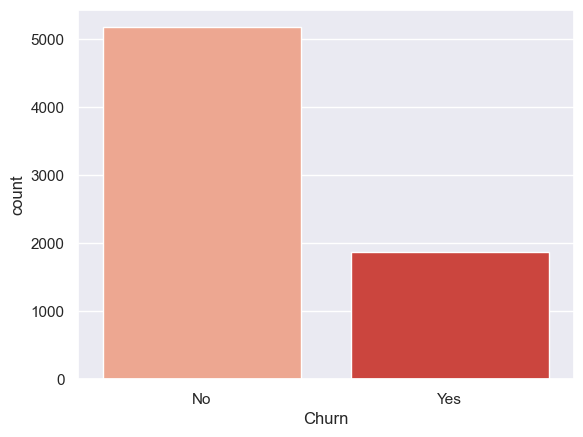

In [319]:
#plotting total churners vs non churners
plt.figure()
plt.text
sns.countplot(x = dataset["Churn"],palette="Reds", hue=dataset["Churn"], legend=False);
#plt.savefig("../Graphs/Churn Count")

In [320]:
#Make a function to plot categorical data according to target
def plot_categorical_to_target(dataset,categorical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(categorical_values)/2)
    
    fig = plt.figure(figsize = (12, 5*number_of_rows))
    
    for index, column in enumerate(categorical_values, 1):
        ax = fig.add_subplot(number_of_rows,number_of_columns,index)
        ax = sns.countplot(x = column, data = dataset, hue = target)
    return plt.show()

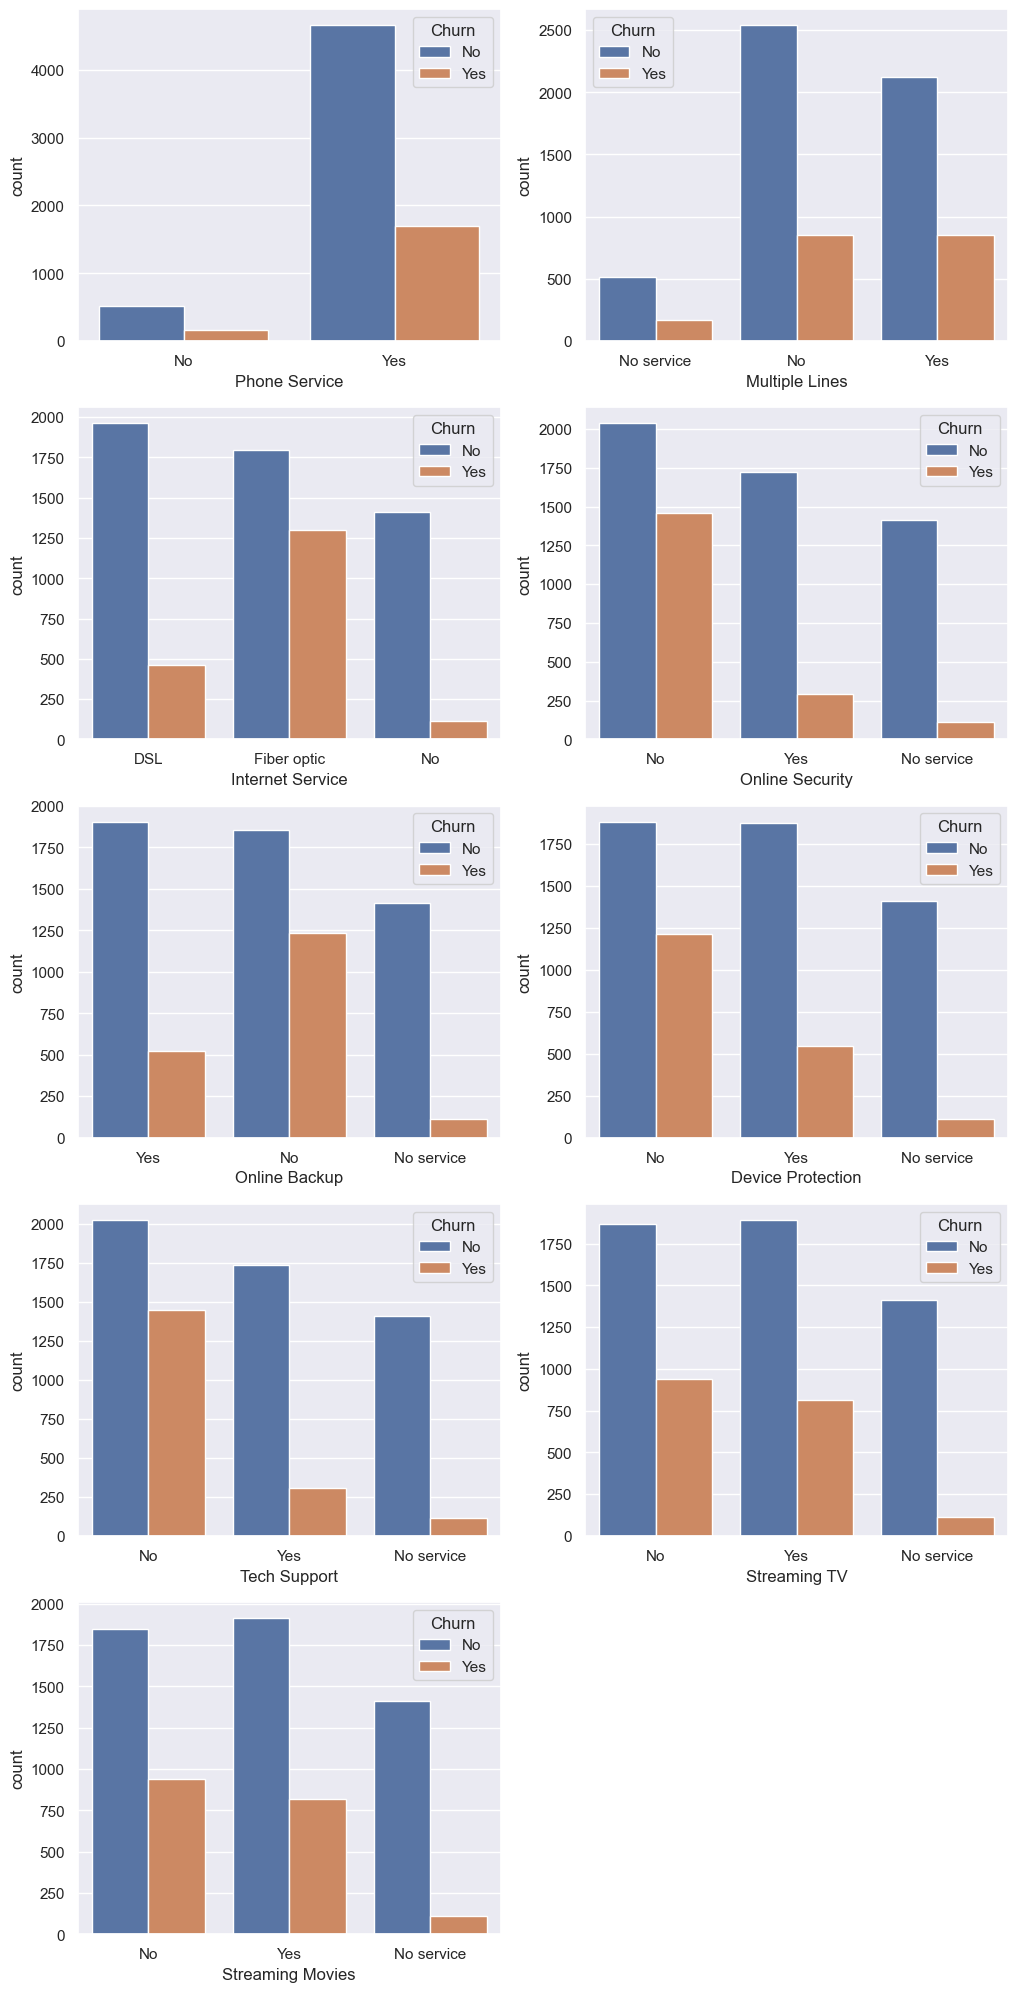

In [321]:
customer_services = ["Phone Service","Multiple Lines","Internet Service","Online Security","Online Backup",
                    "Device Protection","Tech Support","Streaming TV","Streaming Movies"]
#plt.savefig("../Graphs/Customer Service")
plot_categorical_to_target(dataset,customer_services, "Churn");

In [322]:
ordinal_map = {
    1: 'Yes',
    0: 'No'
}
dataset['Senior Citizen'] = dataset['Senior Citizen'].map(ordinal_map)

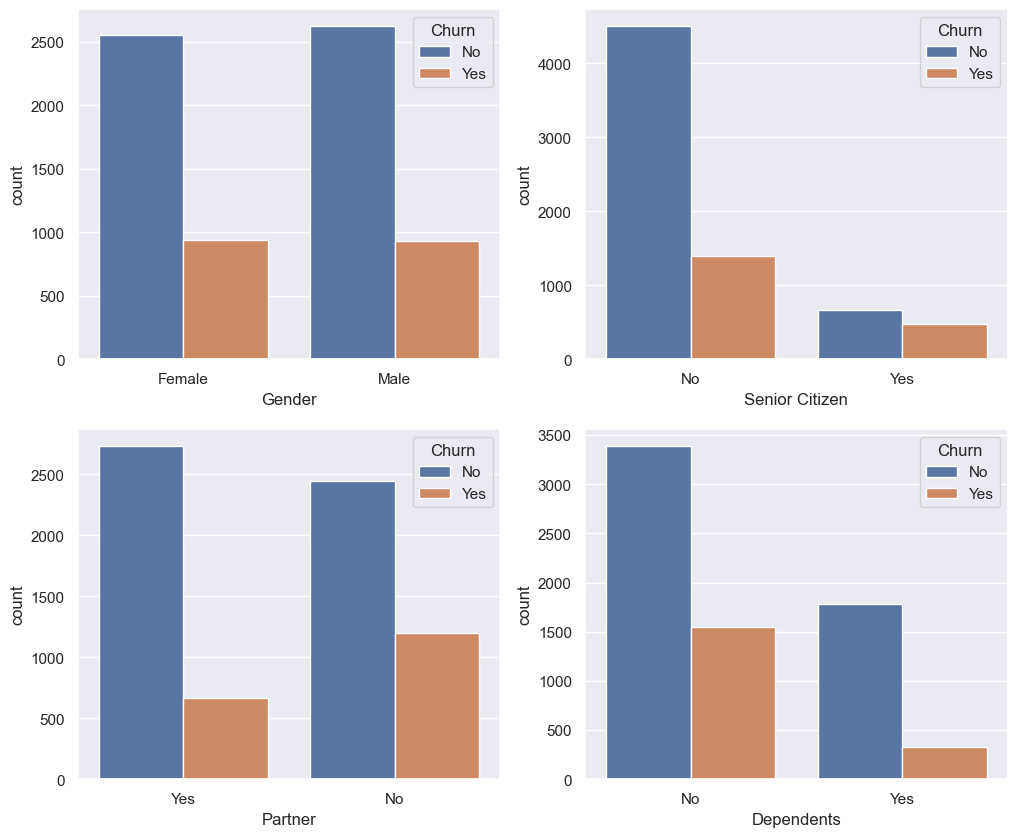

In [323]:
customer_account_cat = ["Gender","Senior Citizen","Partner","Dependents"]
#plt.savefig("../Graphs/Demographic")
plot_categorical_to_target(dataset,customer_account_cat,"Churn")

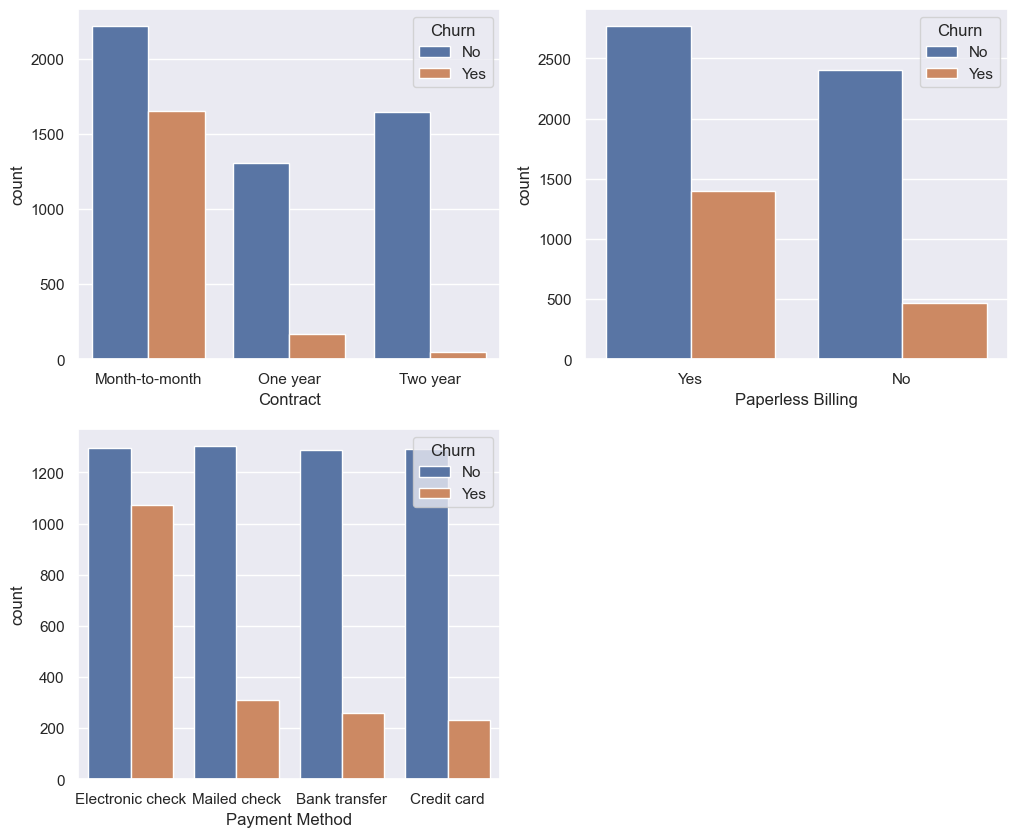

In [324]:
customer_account_cat = ["Contract","Paperless Billing","Payment Method"]
#plt.savefig("../Graphs/Contract Type")
plot_categorical_to_target(dataset,customer_account_cat,"Churn")

In [325]:
def KDE(dataset, numerical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    
    for index, column in enumerate(numerical_values,1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.kdeplot(dataset[column][dataset[target]=="Yes"] ,fill = True)
        ax = sns.kdeplot(dataset[column][dataset[target]=="No"], fill = True)
        ax.legend(["Churn","No Churn"], loc='upper right')
    #plt.savefig("../Graphs/Charges")
    return plt.show()

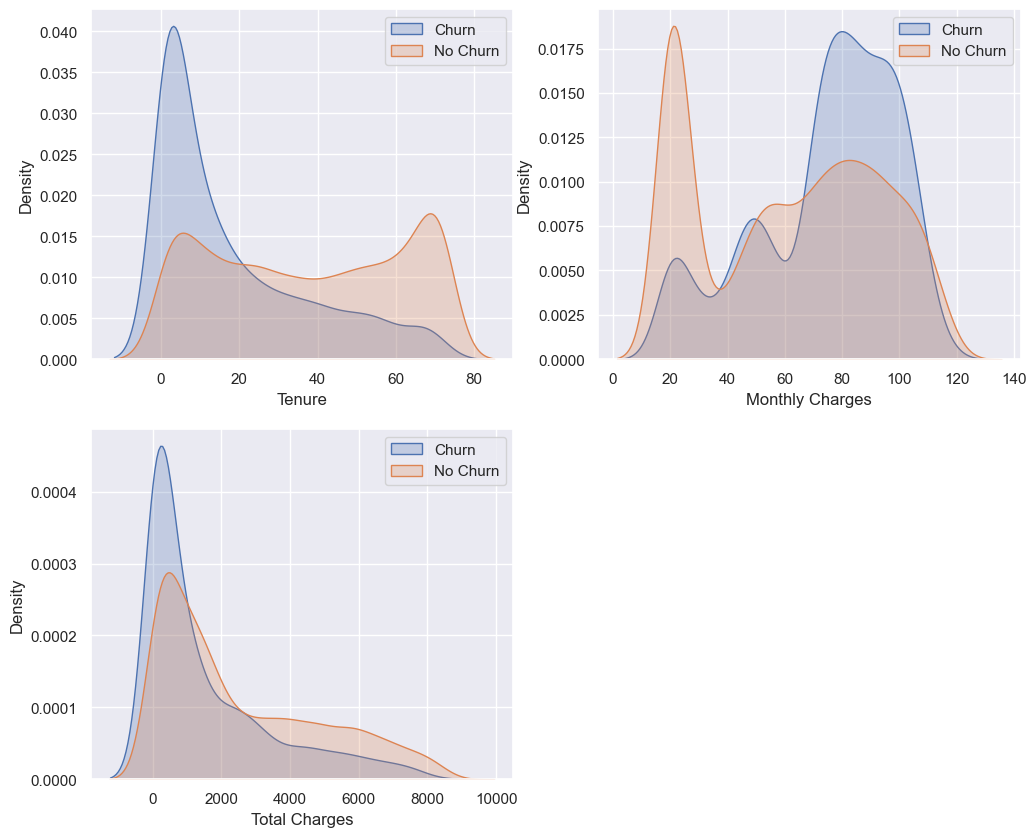

In [326]:
customer_account_num = ["Tenure", "Monthly Charges","Total Charges"]
KDE(dataset,customer_account_num, "Churn")

In [327]:
def outlier_check_boxplot(dataset,numerical_values,Target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    for index, column in enumerate(numerical_values, 1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.boxplot(x = column, data = dataset, hue=Target)
    #plt.savefig("../Graphs/Boxplot Charges")
    return plt.show()

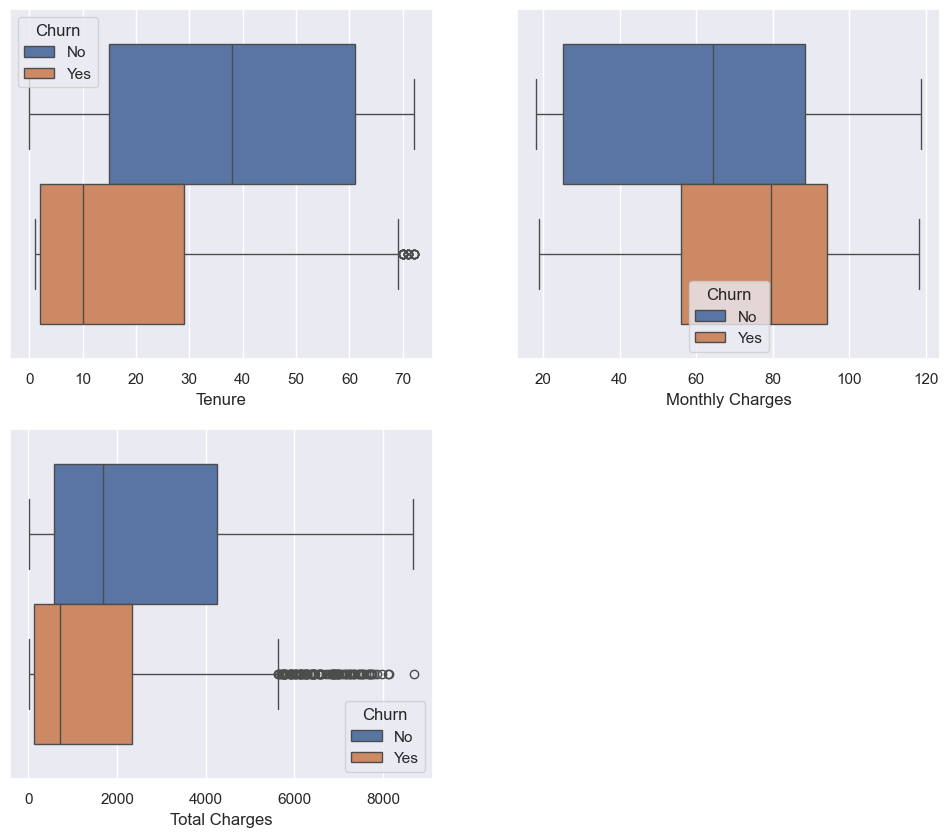

In [328]:
# Numerical Columns Distribution
numerical_values = ["Tenure","Monthly Charges","Total Charges"]
outlier_check_boxplot(dataset,numerical_values,"Churn")

### Ordinal Encoding

In [329]:
# Seperating Categorical Columns based on Mapping Values
categorical_columns_ordinal_1 = [
    'Partner',
    'Dependents',
    'Phone Service',
    'Paperless Billing',
    'Churn'
]
categorical_columns_ordinal_2 = [
    'Multiple Lines',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies'
]

In [330]:
# Mapping Values
ordinal_map_1 = {
    'Yes': 1,
    'No': 0
}
ordinal_map_2 = {
    'Yes': 1,
    'No': 0,
    'No service': -1
}
ordinal_map_3 = {
    'Fiber optic': 1,
    'DSL': 0,
    'No': -1
}
ordinal_map_4 = {
    'Two year': 2,
    'One year': 1,
    'Month-to-month': 0
}
ordinal_map_5 = {
    'Female': 1,
    'Male': 0
}
ordinal_map_6 = {
    'Yes': 1,
    'No': 0
}

In [331]:
# Mapping Values for Different Categorical Columns 
for col in categorical_columns_ordinal_1:
    dataset[col] = dataset[col].map(ordinal_map_1)

for col in categorical_columns_ordinal_2:
    dataset[col] = dataset[col].map(ordinal_map_2)

dataset['Internet Service'] = dataset['Internet Service'].map(ordinal_map_3)
dataset['Contract'] = dataset['Contract'].map(ordinal_map_4)
dataset['Gender'] = dataset['Gender'].map(ordinal_map_5)
dataset['Senior Citizen'] = dataset['Senior Citizen'].map(ordinal_map_6)

### Label Encoding 

In [332]:
# Using Pandas Library to Encode Payment Method Column
dataset = pd.get_dummies(dataset, columns=['Payment Method'], drop_first=True)


In [333]:
dataset['Payment Method_Credit card'] = dataset['Payment Method_Credit card'].astype(int)
dataset['Payment Method_Electronic check'] = dataset['Payment Method_Electronic check'].astype(int)
dataset['Payment Method_Mailed check'] = dataset['Payment Method_Mailed check'].astype(int)

In [334]:
dataset

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method_Credit card,Payment Method_Electronic check,Payment Method_Mailed check
0,1,0,1,0,1,0,-1,0,0,1,...,0,0,0,1,29.85,29.85,0,0,1,0
1,0,0,0,0,34,1,0,0,1,0,...,0,0,1,0,56.95,1889.50,0,0,0,1
2,0,0,0,0,2,1,0,0,1,1,...,0,0,0,1,53.85,108.15,1,0,0,1
3,0,0,0,0,45,0,-1,0,1,0,...,0,0,1,0,42.30,1840.75,0,0,0,0
4,1,0,0,0,2,1,0,1,0,0,...,0,0,0,1,70.70,151.65,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,0,1,0,...,1,1,1,1,84.80,1990.50,0,0,0,1
7039,1,0,1,1,72,1,1,1,0,1,...,1,1,1,1,103.20,7362.90,0,1,0,0
7040,1,0,1,1,11,0,-1,0,1,0,...,0,0,0,1,29.60,346.45,0,0,1,0
7041,0,1,1,0,4,1,1,1,0,0,...,0,0,0,1,74.40,306.60,1,0,0,1


### Correlation Heatmap

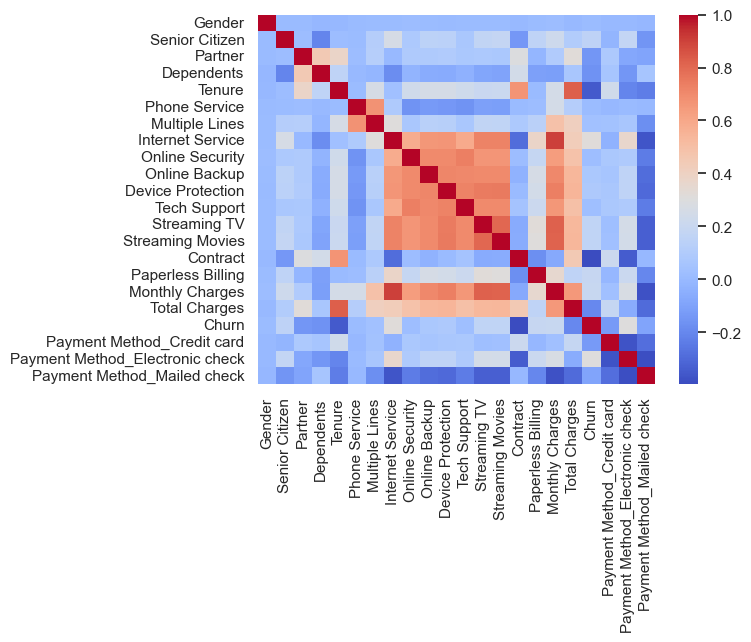

In [335]:
import seaborn as sns
correrlation = dataset.corr()
sns.heatmap(correrlation, cmap='coolwarm');

### Churned Customers

In [336]:
dataset_churned = dataset[dataset["Churn"] == 1]
dataset_churned.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method_Credit card,Payment Method_Electronic check,Payment Method_Mailed check
2,0,0,0,0,2,1,0,0,1,1,...,0,0,0,1,53.85,108.15,1,0,0,1
4,1,0,0,0,2,1,0,1,0,0,...,0,0,0,1,70.70,151.65,1,0,1,0
5,1,0,0,0,8,1,1,1,0,0,...,1,1,0,1,99.65,820.50,1,0,1,0
8,1,0,1,0,28,1,1,1,0,0,...,1,1,0,1,104.80,3046.05,1,0,1,0
13,0,0,0,0,49,1,1,1,0,1,...,1,1,0,1,103.70,5036.30,1,0,0,0


### Seperating Customer for Validation

In [337]:
test = dataset_churned.sample(1)
test

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method_Credit card,Payment Method_Electronic check,Payment Method_Mailed check
4199,0,0,1,0,55,1,1,1,0,0,...,1,1,1,1,104.15,5743.05,1,0,1,0


In [338]:
dataset = dataset.drop(test.index)
dataset.shape

(7042, 22)

### Survival Analysis

In [339]:
# Kaplan Meier
km = KaplanMeierFitter()
km.fit(durations = dataset["Tenure"], event_observed = dataset["Churn"])
tenure = dataset['Tenure']
churn = dataset['Churn']

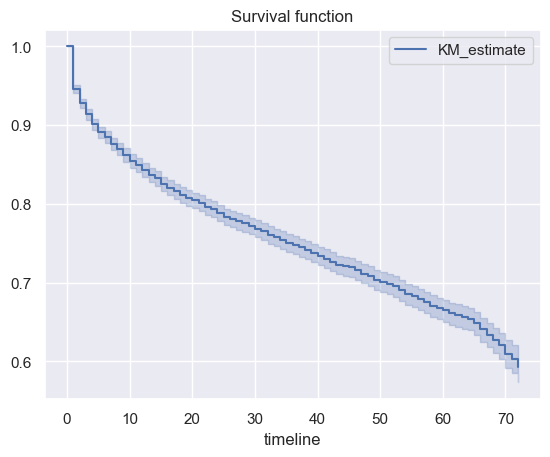

In [340]:
km.plot_survival_function()
plt.title('Survival function');

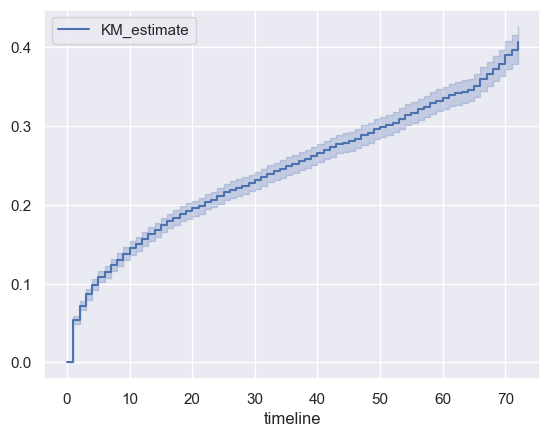

In [341]:
km.plot_cumulative_density();

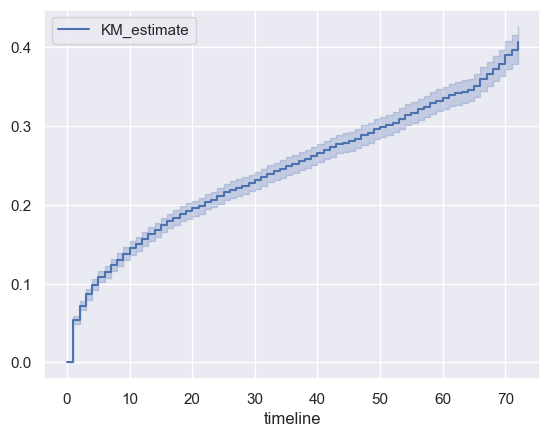

In [342]:
km.plot_cumulative_density();

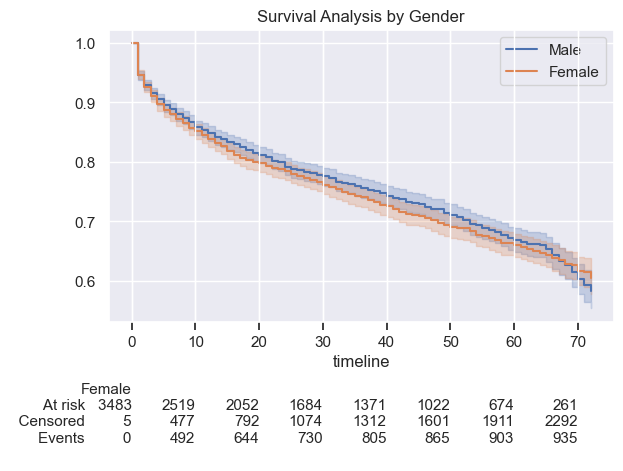

In [343]:
# Survival Analysis by Gender
ax = plt.subplot()
m = (dataset['Gender'] == 0)
km.fit(durations = tenure[m], event_observed = churn[m], label = "Male")
km.plot_survival_function(ax = ax)
km.fit(tenure[~m], event_observed = churn[~m], label = "Female")
km.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title('Survival Analysis by Gender')
plt.show()

In [344]:
median_ = km.median_survival_time_
median_confidence_interval_ = median_survival_times(km.confidence_interval_)
print("Median Survival Time:", median_)
print("Median Confidence Interval:", median_confidence_interval_)

Median Survival Time: inf
Median Confidence Interval:      Female_lower_0.95  Female_upper_0.95
0.5                inf                inf


In [345]:
dataset.Churn = labelencoder.fit_transform(dataset.Churn)
dataset.Churn.value_counts()

Churn
0    5174
1    1868
Name: count, dtype: int64

### Cox Proportional Hazard Model

In [346]:
categorical = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup', 'Device Protection',
       'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract',
       'Paperless Billing']

survivaldata = pd.get_dummies(dataset, columns = categorical, drop_first= True)
survivaldata.head()

,Tenure,Monthly Charges,Total Charges,Churn,Payment Method_Credit card,Payment Method_Electronic check,Payment Method_Mailed check,Gender_1,Senior Citizen_1,Partner_1,...,Device Protection_1,Tech Support_0,Tech Support_1,Streaming TV_0,Streaming TV_1,Streaming Movies_0,Streaming Movies_1,Contract_1,Contract_2,Paperless Billing_1
0,1,29.85,29.85,0,0,1,0,True,False,True,...,False,True,False,True,False,True,False,False,False,True
1,34,56.95,1889.50,0,0,0,1,False,False,False,...,True,True,False,True,False,True,False,True,False,False
2,2,53.85,108.15,1,0,0,1,False,False,False,...,False,True,False,True,False,True,False,False,False,True
3,45,42.30,1840.75,0,0,0,0,False,False,False,...,True,False,True,True,False,True,False,True,False,False
4,2,70.70,151.65,1,0,1,0,True,False,False,...,False,True,False,True,False,True,False,False,False,True


In [347]:
target = dataset[dataset[value_na[0]].isnull()]
target.head()
dataset.dropna(inplace=True)

In [348]:
eventvar = dataset['Churn']
timevar = dataset['Tenure']

In [349]:
cph = CoxPHFitter()
cph.fit(dataset, duration_col='Tenure', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7031 total observations, 5163 right-censored observations>
             duration col = 'Tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7031
number of events observed = 1868
   partial log-likelihood = -12665.87
         time fit was run = 2024-04-26 15:26:41 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
Gender                           0.04      1.04      0.05           -0.06            0.13                0.95                1.13
Senior Citizen                   0.03      1.03      0.06           -0.08            0.14                0.93                1.16
Partner                         -0.19      0.83      0.06           -0.29           -0.08                0.75                0.93
Dependents                      -0.09      0.92      0.07           -0.22            0.05                0.80                1.05
Phone Service                    1.12      3.08      0.17            0.78            1.47                2.19                4.33
Multiple Lines                   0.20      1.22      0.06            0.08            0.32                1.09                1.38
Internet Service                 1.62      5.07      0.14            1.36            1.89                3.88                6.63
Online Security                 -0.07      0.93      0.06           -0.19            0.05                0.83                1.05
Online Backup                    0.08      1.08      0.05           -0.03            0.18                0.97                1.20
Device Protection                0.23      1.25      0.06            0.12            0.34                1.12                1.40
Tech Support                     0.05      1.05      0.06           -0.07            0.17                0.93                1.19
Streaming TV                     0.53      1.71      0.08            0.39            0.68                1.47                1.98
Streaming Movies                 0.54      1.71      0.08            0.39            0.69                1.47                1.99
Contract                        -1.61      0.20      0.08           -1.78           -1.45                0.17                0.23
Paperless Billing                0.15      1.16      0.06            0.04            0.26                1.04                1.30
Monthly Charges                 -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
Total Charges                   -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Payment Method_Credit card      -0.01      0.99      0.09           -0.19            0.16                0.83                1.18
Payment Method_Electronic check  0.39      1.47      0.07            0.24            0.53                1.27                1.70
Payment Method_Mailed check      0.51      1.66      0.09            0.34            0.68                1.40                1.97

                                 cmp to      z      p  -log2(p)
covariate                                                      
Gender                             0.00   0.76   0.45      1.16
Senior Citizen                     0.00   0.60   0.55      0.86
Partner                            0.00  -3.36 <0.005     10.34
Dependents                         0.00  -1.23   0.22      2.18
Phone Service                      0.00   6.44 <0.005     32.94
Multiple Lines                     0.00   3.33 <0.005     10.18
Internet Service                   0.00  11.88 <0.005    105.64
Online Security                    0.00  -1.17   0.24      2.04
Online Backup                      0.00   1.41   0.16      2.67
Device Protection                  0.00   4.02 <0.005     14.07
Tech S

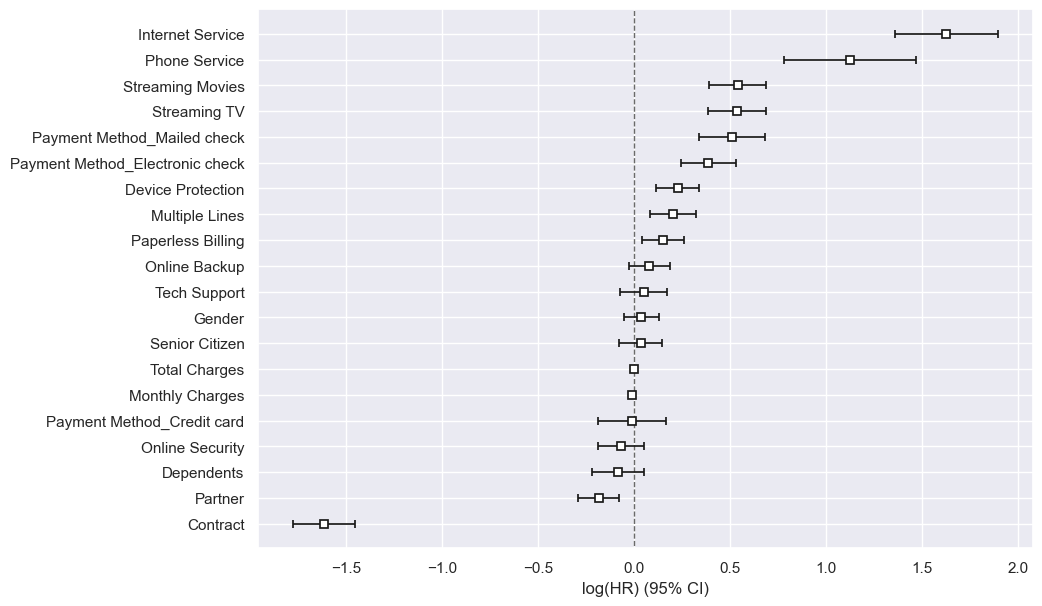

In [350]:
fig, ax = plt.subplots(figsize = (10,7))
cph.plot(ax = ax);

### Testing Survival Function for Churned Customer

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method_Credit card,Payment Method_Electronic check,Payment Method_Mailed check
4199,0,0,1,0,55,1,1,1,0,0,...,1,1,1,1,104.15,5743.05,1,0,1,0


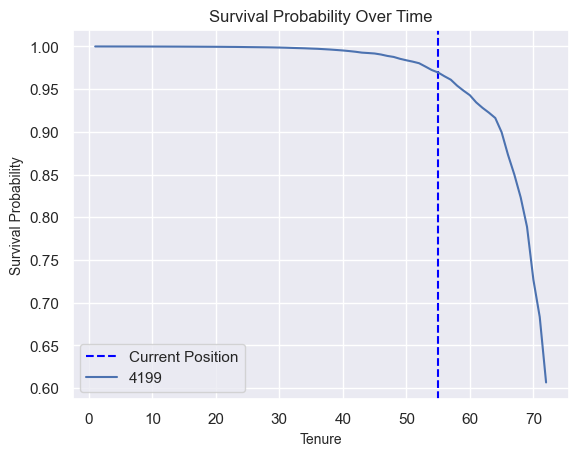

In [351]:
fig, ax = plt.subplots()
plt.axvline(x=test.iloc[0:11,:].Tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Current Position'])
cph.predict_survival_function(test.iloc[0:11,:]).plot(ax = ax)
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Survival Probability', size = 10)
ax.set_title('Survival Probability Over Time')
test

### Survival Analysis for Target Customers

In [352]:
target = target.replace(np.nan, 0)

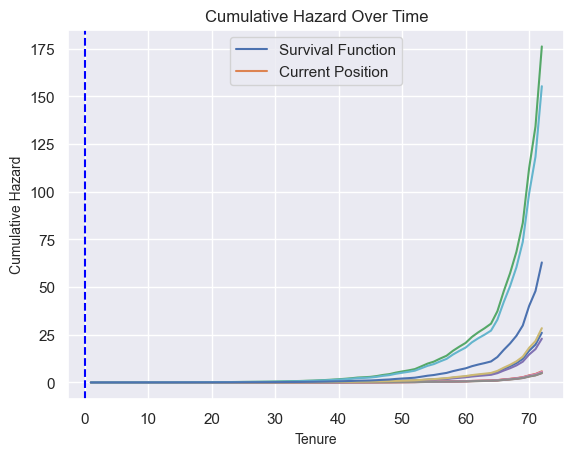

In [353]:
fig, ax = plt.subplots()
cph.predict_cumulative_hazard(target.iloc[0:11,:]).plot(ax = ax)
plt.axvline(x=target.iloc[0:11,:].Tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Survival Function','Current Position'])
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Cumulative Hazard', size = 10)
ax.set_title('Cumulative Hazard Over Time');

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method_Credit card,Payment Method_Electronic check,Payment Method_Mailed check
488,1,0,1,1,0,0,-1,0,1,0,...,1,0,2,1,52.55,0.0,0,0,0,0
753,0,0,0,1,0,1,0,-1,-1,-1,...,-1,-1,2,0,20.25,0.0,0,0,0,1
936,1,0,1,1,0,1,0,0,1,1,...,1,1,2,0,80.85,0.0,0,0,0,1
1082,0,0,1,1,0,1,1,-1,-1,-1,...,-1,-1,2,0,25.75,0.0,0,0,0,1
1340,1,0,1,1,0,0,-1,0,1,1,...,1,0,2,0,56.05,0.0,0,1,0,0
3331,0,0,1,1,0,1,0,-1,-1,-1,...,-1,-1,2,0,19.85,0.0,0,0,0,1
3826,0,0,1,1,0,1,1,-1,-1,-1,...,-1,-1,2,0,25.35,0.0,0,0,0,1
4380,1,0,1,1,0,1,0,-1,-1,-1,...,-1,-1,2,0,20.00,0.0,0,0,0,1
5218,0,0,1,1,0,1,0,-1,-1,-1,...,-1,-1,1,1,19.70,0.0,0,0,0,1
6670,1,0,1,1,0,1,1,0,0,1,...,1,0,2,0,73.35,0.0,0,0,0,1


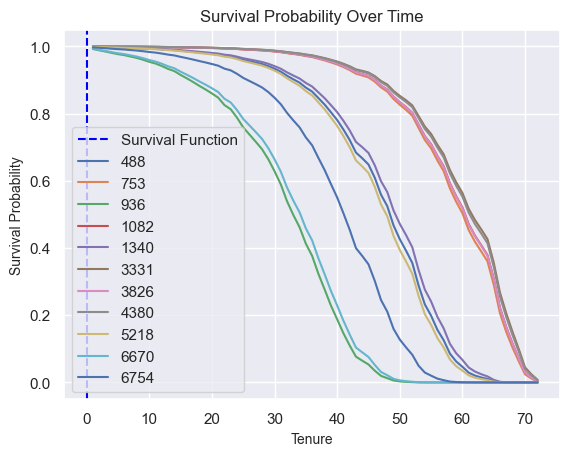

In [354]:
fig, ax = plt.subplots()
plt.axvline(x=target.iloc[0:11,:].Tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Survival Function','Current Position'])
cph.predict_survival_function(target.iloc[0:11,:]).plot(ax = ax)
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Survival Probability', size = 10)
ax.set_title('Survival Probability Over Time')
target

In [355]:
def LTV(info):
    life = cph.predict_survival_function(info).reset_index()
    life.columns = ['Tenure', 'Probability']
    max_life = life.Tenure[life.Probability > 0.1].max()
    
    LTV = max_life * info['Monthly Charges'].values[0]
    return LTV

In [356]:
print(f'LTV of a Customer 488 is: {LTV(target[0:1]):.2f} dollars.')
print('LTV of a Customer 753 is:', LTV(target[1:2]), 'dollars.')
print('LTV of a Customer 936 is:', LTV(target[2:3]), 'dollars.')
print('LTV of a Customer 1082 is:', LTV(target[3:4]), 'dollars.')
print('LTV of a Customer 1340 is:', LTV(target[4:5]), 'dollars.')
print('LTV of a Customer 3331 is:', LTV(target[5:6]), 'dollars.')
print('LTV of a Customer 3826 is:', LTV(target[6:7]), 'dollars.')
print('LTV of a Customer 4380 is:', LTV(target[7:8]), 'dollars.')
print('LTV of a Customer 5218 is:', LTV(target[8:9]), 'dollars.')
print('LTV of a Customer 6670 is:', LTV(target[9:10]), 'dollars.')
print('LTV of a Customer 6754 is:', LTV(target[10:11]), 'dollars.')

LTV of a Customer 488 is: 2995.35 dollars.
LTV of a Customer 753 is: 1377.0 dollars.
LTV of a Customer 936 is: 3395.7 dollars.
LTV of a Customer 1082 is: 1751.0 dollars.
LTV of a Customer 1340 is: 3250.8999999999996 dollars.
LTV of a Customer 3331 is: 1349.8000000000002 dollars.
LTV of a Customer 3826 is: 1723.8000000000002 dollars.
LTV of a Customer 4380 is: 1360.0 dollars.
LTV of a Customer 5218 is: 1122.8999999999999 dollars.
LTV of a Customer 6670 is: 3154.0499999999997 dollars.
LTV of a Customer 6754 is: 3156.9 dollars.


### Extracting Variables

In [357]:
# Independent Variables
X = dataset.drop(columns=['Churn'], axis=1)

# Dependent Variable
y = dataset.loc[:, 'Churn']

### Splitting Data

In [358]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

### Feature Scaling

In [359]:
# Standard Scaler will Scale Values between -3 to +3
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### GridSearchCV (LR, KNS, SVC, GNB, DTC, RFC)

In [391]:
# Models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

# Model Parameters
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 300, 500],
        'max_depth': [10, 20, 30, None]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GaussianNB': {}
}

results = []

# Grid Search with Cross Validation
for key, value in models.items():
    grid_search = GridSearchCV(estimator=value, param_grid=param_grids[key],cv=10, n_jobs=-1, refit='accuracy', scoring=['accuracy','precision','recall'])
    grid_search.fit(X=X_train_scaled, y=y_train)
    print(f'\n{key}')
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}\n{'-' * 85}")
    metrics_df = pd.DataFrame(grid_search.cv_results_)
    relevant_columns = ['mean_test_precision', 'mean_test_recall']
    metrics_df = metrics_df[relevant_columns].mean()
    results.append({'Model': key, 'Params': grid_search.best_params_, 'Accuracy': grid_search.best_score_, 'Precision': metrics_df['mean_test_precision', 'Recall': metrics_df['mean_test_recall']]})

grid_search_df = pd.DataFrame(results)


LogisticRegression
Best parameters: {'C': 0.1}
Best cross-validation accuracy: 0.808138594084815
-------------------------------------------------------------------------------------


KeyError: 'key of type tuple not found and not a MultiIndex'

### GridSearch Results

In [361]:
best_score = grid_search.best_score_
best_params = grid_search.best_params_
model = grid_search.best_estimator_

print("Best Score:", best_score)
print("Best Parameters:", best_params)
print("Best Model:", model)

Best Score: 0.8013852455389594
Best Parameters: {'max_depth': 10, 'n_estimators': 300}
Best Model: RandomForestClassifier(max_depth=10, n_estimators=300)


In [385]:
gcv =pd.DataFrame(grid_search.cv_results_)


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [383]:
gcv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

### Random Forest

In [362]:
# Fitting Model
model.fit(X_train_scaled, y_train)

# Making Prediction
y_pred = model.predict(X_test_scaled)

# Metrics
model_accuracy = accuracy_score(y_pred, y_test)
model_precision = precision_score(y_pred, y_test)
model_recall = recall_score(y_pred, y_test)
model_cm = confusion_matrix(y_pred, y_test)

### XGBoost

In [363]:
# Initialising Model
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=5,
    random_state=21
)

# Fitting Model
xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

# Making Prediction
y_pred = xgb.predict(X_test_scaled)

# Metrics
xgb_accuracy = accuracy_score(y_pred, y_test) *100
xgb_precision = precision_score(y_pred, y_test)
xgb_recall = recall_score(y_pred, y_test)
xgb_cm = confusion_matrix(y_pred, y_test)
xgb_accuracy

77.46979388770433

### Artificial Neural Network

In [364]:
# Initialising Model
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling Model
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting Model
ann.fit(X_train, y_train, epochs=50, batch_size=32)

# Making Prediction
y_pred = ann.predict(X_test) > 0.5

# Metrics
ann_accuracy = accuracy_score(y_pred, y_test) * 100
ann_precision = precision_score(y_pred, y_test)
ann_recall = recall_score(y_pred, y_test)
ann_cm = confusion_matrix(y_pred, y_test)
ann_accuracy

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.7231 - loss: 36.7345 
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.7377 - loss: 1.4807
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.7289 - loss: 1.3914
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.7477 - loss: 1.1489
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.7398 - loss: 0.9715
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.7417 - loss: 1.1682
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.7413 - loss: 1.0685
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.7603 - loss: 0.8344
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.7460 - loss: 1.0398
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.7570 - loss: 0.9250
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.7497 - loss: 1.1254
Epoch 12/50
176/176 ━━━━━━━━

78.53589196872778

### Metrics Dataframe

In [365]:
results

[{'Model': 'LogisticRegression',
  'Params': {'C': 0.1},
  'Accuracy': 0.808138594084815},
 {'Model': 'KNeighborsClassifier',
  'Params': {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'},
  'Accuracy': 0.7676042805762217},
 {'Model': 'SVC',
  'Params': {'C': 1, 'gamma': 'scale'},
  'Accuracy': 0.8024487525521007},
 {'Model': 'GaussianNB', 'Params': {}, 'Accuracy': 0.7348896670733173},
 {'Model': 'DecisionTreeClassifier',
  'Params': {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5},
  'Accuracy': 0.7679576240652832},
 {'Model': 'RandomForestClassifier',
  'Params': {'max_depth': 10, 'n_estimators': 300},
  'Accuracy': 0.8013852455389594}]

In [366]:
results_df

,model,params,accuracy,Model,Best Accuracy
0,LogisticRegression,{'C': 10},0.806360,NaN,NaN
1,KNeighborsClassifier,"{'algorithm': 'auto', 'n_neighbors': 9, 'weigh...",0.769561,NaN,NaN
2,SVC,"{'C': 1, 'gamma': 'scale'}",0.804405,NaN,NaN
3,GaussianNB,{},0.732576,NaN,NaN
4,DecisionTreeClassifier,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.766001,NaN,NaN
5,RandomForestClassifier,"{'max_depth': 10, 'n_estimators': 300}",0.800319,NaN,NaN
6,NaN,NaN,NaN,XGBoost,0.772566
7,NaN,NaN,NaN,Artificial Neural Network,0.792466
8,NaN,NaN,NaN,XGBoost,77.256574
9,NaN,NaN,NaN,Artificial Neural Network,76.901208


In [375]:
results.append({'Model': 'XGBoost', 'Params': '{}', 'Accuracy': xgb_accuracy, 'Precision':xgb_precision, 'Recall': xgb_recall})
results.append({'Model': 'Artificial Neural Network', 'Params': '{}', 'Accuracy': ann_accuracy,'Precision':ann_precision, 'Recall': ann_recall})
results_df = pd.DataFrame(results)

In [376]:
from tabulate import tabulate
results_df.reset_index(drop=True, inplace=True)
table = tabulate(results_df, headers='keys', tablefmt='psql')
print(table)

+----+---------------------------+------------------------------------------------------------------+------------+-------------+------------+
|    | Model                     | Params                                                           |   Accuracy |   Precision |     Recall |
|----+---------------------------+------------------------------------------------------------------+------------+-------------+------------|
|  0 | LogisticRegression        | {'C': 0.1}                                                       |   0.808139 |  nan        | nan        |
|  1 | KNeighborsClassifier      | {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}    |   0.767604 |  nan        | nan        |
|  2 | SVC                       | {'C': 1, 'gamma': 'scale'}                                       |   0.802449 |  nan        | nan        |
|  3 | GaussianNB                | {}                                                               |   0.73489  |  nan        | nan        |
|  4 |

In [369]:
metrics_df = pd.DataFrame([[model_accuracy, model_precision, model_recall, xgb_accuracy, xgb_precision, xgb_recall, ann_accuracy, ann_precision, ann_recall]], columns=['random_forest_accuracy', 'random_forest_precision', 'random_forest_recall', 'xgboost_accuracy', 'xgboost_precision', 'xgboost_recall', 'artificial_neural_network_accuracy', 'artificial_neural_network_precision', 'artificial_neural_network_recall'])

In [370]:
metrics_df.reset_index(drop=True, inplace=True)
metrics = tabulate(metrics_df, headers='keys', tablefmt='psql')
print(metrics)

+----+--------------------------+---------------------------+------------------------+--------------------+---------------------+------------------+--------------------------------------+---------------------------------------+------------------------------------+
|    |   random_forest_accuracy |   random_forest_precision |   random_forest_recall |   xgboost_accuracy |   xgboost_precision |   xgboost_recall |   artificial_neural_network_accuracy |   artificial_neural_network_precision |   artificial_neural_network_recall |
|----+--------------------------+---------------------------+------------------------+--------------------+---------------------+------------------+--------------------------------------+---------------------------------------+------------------------------------|
|  0 |                 0.794598 |                  0.511166 |               0.691275 |            77.4698 |            0.277916 |         0.811594 |                              78.5359 |                  

In [371]:
print(metrics_df)

   random_forest_accuracy  random_forest_precision  random_forest_recall  \
0                0.794598                 0.511166              0.691275   

   xgboost_accuracy  xgboost_precision  xgboost_recall  \
0         77.469794           0.277916        0.811594   

   artificial_neural_network_accuracy  artificial_neural_network_precision  \
0                           78.535892                             0.615385   

   artificial_neural_network_recall  
0                          0.627848  


### Confusion Matrix

In [372]:
print('Random Forest:', model_cm)
print('XGBoost:', xgb_cm)
print('Artificial Neural Network:', ann_cm)

Random Forest: [[912 197]
 [ 92 206]]
XGBoost: [[978 291]
 [ 26 112]]
Artificial Neural Network: [[857 155]
 [147 248]]


### LIME(Local Interpretable Model-agnostic Explanations)

In [373]:
# Initialising Explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    mode='classification'
)

In [374]:
# Plotting Explainer
exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=model.predict_proba
)
exp.show_in_notebook(show_table=True)

/Users/rishavhalder/Library/Python/3.9/lib/python/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/rishavhalder/Library/Python/3.9/lib/python/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/rishavhalder/Library/Python/3.9/lib/python/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consi